In [186]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import torch
import random
from pytorchtools import EarlyStopping

In [187]:
df = pd.read_csv("~/python_project/AI_project/data/data_by_all_20230518.csv")

In [188]:
#월별 oil price data 생성
oil = df[['ID', 'oil_price']]

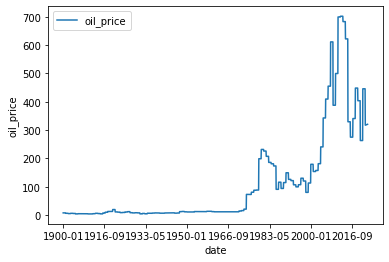

In [189]:
#x축 ID(1900-01 ~ 2022-12), y축이 oil price인 그래프 생성
oil.set_index(df['ID']).plot()
plt.xlabel('date')
plt.ylabel('oil_price')
plt.show()

In [190]:
#ID를 연, 월로 분리하고 int로 형변환해 [연, 월] 형태의 리스트 생성
date_strings = np.array([date.split('-') for date in oil['ID']])
dates = []
for date_string in date_strings:
    date = [int(val) for val in date_string]
    dates.append(date)

In [191]:
#input: 연 월, output(target): co2
X = np.array(dates)
y = oil['oil_price'].values

In [192]:
#input dimesion과 batch size, sequence 길이 설정
seq_length = 12
input_size = X.shape[1]
batch_size = 4

In [193]:
#원하는 sequence만큼 data를 이어줌 (num_data,sequence_length, input_size)형태)
def data_to_seq(data, input_size, seq_length):
    data_seq = np.array([])
    for i in range(0, data.shape[0] - (seq_length - 1)):
        data_seq = np.append(data_seq, data[i:i + seq_length])
    return data_seq.reshape(-1, seq_length, input_size)

In [194]:
#Minmax scaler를 통해 normalize
#나올 수 있는 모든 값들이 random하게 선택되었다는 가정하에 전체 데이터셋에 대하여 scaling 진행
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [195]:
#input data를 sequential하게 이어줌
X_seq = data_to_seq(data = X_scaled, input_size = input_size,seq_length = seq_length)

In [196]:
#train, validation, test set 분리
X_train, X_test, y_train, y_test = train_test_split(X_seq[:-1], y[seq_length:], test_size = 0.4, random_state = 0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 0)

In [197]:
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_val = torch.FloatTensor(y_val)
y_test = torch.FloatTensor(y_test)

In [198]:
train = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train, batch_size = batch_size, shuffle=True)

validation = TensorDataset(X_val, y_val)
valid_dataloader = DataLoader(validation, batch_size = batch_size, shuffle=False)

test = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test, batch_size = batch_size, shuffle=False)

In [199]:
#LSTM
class LSTM_model(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM_model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.lstm = torch.nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True
        )

        self.fc = torch.nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        x = x.to(device)
        y, hidden = self.lstm(x)
        y = y[:,-1,:]
        y = self.fc(y)
        return y.view(-1)

In [200]:
#RNN
class RNN_model(torch.nn.Module):
    def __init__(self,input_size, hidden_size, output_size, num_layers):
        super(RNN_model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.rnn_layer = torch.nn.RNN(
            input_size = self.input_size,
            hidden_size = self.hidden_size, 
            num_layers = self.num_layers, 
            batch_first = True)
        self.fc = torch.nn.Linear(hidden_size, output_size) 
    def forward(self,x):
        x = x.to(device)
        y, hidden = self.rnn_layer(x)
        y = y[:,-1, :]
        y = self.fc(y)
        return y.view(-1)

In [201]:
#GRU
class GRU_model(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRU_model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.gru = torch.nn.GRU(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True
        )

        self.fc = torch.nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        x = x.to(device)
        y, hidden = self.gru(x)
        y = y[:,-1,:]
        y = self.fc(y)
        return y.view(-1)


In [202]:
def validation(model, dataloader, loss_fn, device):
    model.eval()
    val_loss = 0
    num_batch = len(dataloader)
    with torch.no_grad():
        for x, y_true  in dataloader:
            x, y_true = x.to(device), y_true.to(device)
            y_pred = model(x)
            loss = loss_fn(y_true, y_pred)
            val_loss += loss.item()
    val_loss /= num_batch
    return val_loss

In [203]:
def train(model, dataloader, eval_dataloader, loss_fn, optim, epochs, device, patience, verbose = False):
    early_stopping = EarlyStopping(patience = patience, verbose = verbose)
    num_batch = len(dataloader)
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0
        for x, y_true in dataloader:
            x, y_true = x.to(device), y_true.to(device)
            y_pred = model(x)
            loss = loss_fn(y_true, y_pred)
            train_loss += loss.item()
            optim.zero_grad()
            loss.backward()
            optim.step()
        train_loss /= num_batch
        val_loss = validation(model, eval_dataloader, loss_fn, device)
        
        #patience만큼의 epoch동안 validation loss가 줄어들지 않을 시 early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f'Early stopping, Epoch: {epoch}, Train Loss: {train_loss:.8f}, Validation Loss: {val_loss:.8f}')
            break
        if epoch % 20 == 0:
            print(f'Epoch: {epoch}, Train Loss: {train_loss:.8f}, Validation Loss: {val_loss:.8f}')
    return train_loss

In [204]:
# learning late, hidden size, layer 수, output dimesion, epoch, device, patience, verbose 설정
# patience: early stopping을 결정하는 validation loss가 연속해서 줄어들지 않는 epoch 수
# verbose: True면 epoch마다 validation loss가 얼마나 줄었는지 출력됨
lr = 0.001
hidden_size = 10
num_layers = 1
output_size = 1
epochs = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
patience = 30
verbose = False

In [205]:
#RNN 모델
model_1 = RNN_model(input_size, hidden_size, output_size, num_layers).to(device)
loss_func_1 = torch.nn.MSELoss().to(device)
optim_1 = torch.optim.Adam(params=model_1.parameters(), lr = lr )


In [206]:
#LSTM 모델
model_2 = LSTM_model(input_size, hidden_size, output_size, num_layers).to(device)
loss_func_2 = torch.nn.MSELoss().to(device)
optim_2 = torch.optim.Adam(params=model_2.parameters(), lr = lr )

In [207]:
#GRU 모델
model_3 = GRU_model(input_size, hidden_size, output_size, num_layers).to(device)
loss_func_3 = torch.nn.MSELoss().to(device)
optim_3 = torch.optim.Adam(params=model_3.parameters(), lr = lr )

In [208]:
#RNN 모델 training
train(model = model_1, dataloader = train_dataloader, eval_dataloader = valid_dataloader, loss_fn = loss_func_1, 
      optim = optim_1, epochs = epochs, device = device, patience = patience, verbose = verbose)

Epoch: 20, Train Loss: 31833.93988731, Validation Loss: 36962.69651341
Epoch: 40, Train Loss: 28872.96377508, Validation Loss: 33470.20535031
Epoch: 60, Train Loss: 24225.78559466, Validation Loss: 28204.13428396
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
Epoch: 80, Train Loss: 20323.97720171, Validation Loss: 23902.92687151
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
Epoch: 100, Train Loss: 18491.14000228, Validation Loss: 21310.60795258
EarlyStopping counter: 2 out of 30
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 2 out of 30
EarlyStopping counter: 3 out of 30
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 2 out of 30
EarlyStopping counter: 3 out of 30
EarlyStopping counter: 4 out of 30
EarlyStopping 

4765.0161312666805

In [209]:
#LSTM 모델 training
train(model = model_2, dataloader = train_dataloader, eval_dataloader = valid_dataloader, loss_fn = loss_func_2, 
      optim = optim_2, epochs = epochs, device = device, patience = patience, verbose = verbose)

Epoch: 20, Train Loss: 31243.15317505, Validation Loss: 36174.89818869
EarlyStopping counter: 1 out of 30
Epoch: 40, Train Loss: 25982.50409053, Validation Loss: 30281.90245205
EarlyStopping counter: 1 out of 30
Epoch: 60, Train Loss: 21778.95586076, Validation Loss: 25461.69595716
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
Epoch: 80, Train Loss: 18425.85217170, Validation Loss: 21822.35318448
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
Epoch: 100, Train Loss: 16181.81857510, Validation Loss: 18965.70599633
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
Epoch: 120, Train Loss: 13924.83447684, Validation Loss: 16578.41561899
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
Epoch: 140, Train Loss: 12025.86920271, Validation Loss: 14214.63172704
EarlyStopp

3237.1210767380217

In [210]:
#GRU 모델 training
train(model = model_3, dataloader = train_dataloader, eval_dataloader = valid_dataloader, loss_fn = loss_func_3, 
      optim = optim_3, epochs = epochs, device = device, patience = patience, verbose = verbose)

Epoch: 20, Train Loss: 32008.51765067, Validation Loss: 36984.44351691
Epoch: 40, Train Loss: 27547.44728370, Validation Loss: 31806.52149768
Epoch: 60, Train Loss: 22626.52653365, Validation Loss: 26510.35113939
Epoch: 80, Train Loss: 19063.32235220, Validation Loss: 22518.19229405
EarlyStopping counter: 1 out of 30
Epoch: 100, Train Loss: 16471.89510139, Validation Loss: 19484.29986821
EarlyStopping counter: 1 out of 30
Epoch: 120, Train Loss: 14677.96189840, Validation Loss: 17300.87548551
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
Epoch: 140, Train Loss: 13370.57753212, Validation Loss: 15881.92630194
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
Epoch: 160, Train Loss: 12572.06395743, Validation Loss: 14783.85935141
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 2 out of 30
EarlyStopping counter: 1 out of 30
EarlySto

2895.804684682986

In [211]:
#RNN 모델 test loss
print(f'model_1(RNN) Test Loss: {validation(model_1, test_dataloader, loss_func_1, device):.8f}')

model_1(RNN) Test Loss: 4717.57014612


In [212]:
#LSTM 모델 test loss
print(f'model_2(LSTM) Test Loss: {validation(model_2, test_dataloader, loss_func_2, device):.8f}')

model_2(LSTM) Test Loss: 3145.64124074


In [213]:
#GRU 모델 test loss
print(f'model_3(GRU) Test Loss: {validation(model_3, test_dataloader, loss_func_3, device):.8f}')

model_3(GRU) Test Loss: 3161.53913799


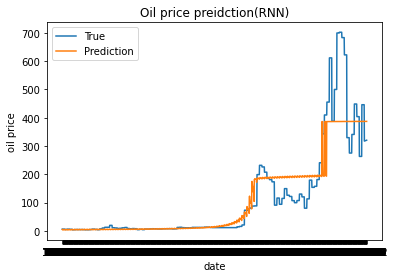

In [271]:
#x축 date(1900-01 ~ 2022-12) y축 oil price인 true값 그래프와 RNN모델 예측값 그래프 생성
plt.plot(oil.ID.values[seq_length:], oil['oil_price'][seq_length:], label = 'True')
plt.plot(oil.ID.values[seq_length:], model_1(torch.FloatTensor(X_seq)).cpu().detach().numpy()[:-1], label = 'Prediction')
plt.xlabel('date')
plt.ylabel('oil price')
plt.title('Oil price preidction(RNN)')
plt.legend()
plt.show()

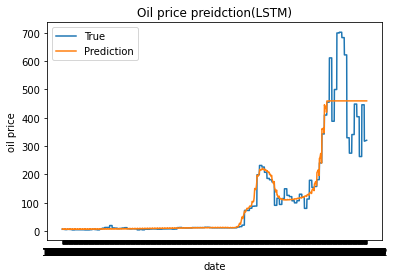

In [272]:
#x축 date(1900-01 ~ 2022-12) y축 oil price인 true값 그래프와 LSTM모델 예측값 그래프 생성
plt.plot(oil.ID.values[seq_length:], oil['oil_price'][seq_length:], label = 'True')
plt.plot(oil.ID.values[seq_length:], model_2(torch.FloatTensor(X_seq)).cpu().detach().numpy()[:-1], label = 'Prediction')
plt.xlabel('date')
plt.ylabel('oil price')
plt.title('Oil price preidction(LSTM)')
plt.legend()
plt.show()

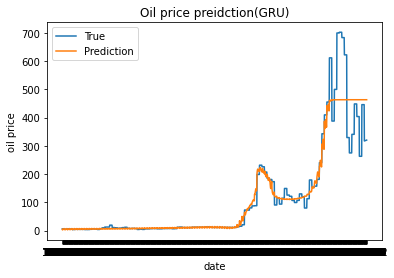

In [274]:
#x축 date(1900-01 ~ 2022-12) y축 oil price인 true값 그래프와 GRU모델 예측값 그래프 생성
plt.plot(oil.ID.values[seq_length:], oil['oil_price'][seq_length:], label = 'True')
plt.plot(oil.ID.values[seq_length:], model_3(torch.FloatTensor(X_seq)).cpu().detach().numpy()[:-1], label = 'Prediction')
plt.xlabel('date')
plt.ylabel('oil price')
plt.title('Oil price preidction(GRU)')
plt.legend()
plt.show()

In [217]:
#RNN, LSTM, GRU을 ensemble한 model
class Ensemble_Model_1(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(Ensemble_Model_1, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.gru_model = GRU_model(input_size, hidden_size, output_size, num_layers)
        self.rnn_model = RNN_model(input_size, hidden_size, output_size, num_layers)
        self.lstm_model = LSTM_model(input_size, hidden_size, output_size, num_layers)

    def forward(self, x):
        x = x.to(device)
        output_gru = self.gru_model(x)
        output_rnn = self.rnn_model(x)
        output_lstm = self.lstm_model(x)
        output = torch.vstack((output_rnn, output_lstm))
        output = torch.vstack((output, output_gru))
        output = torch.mean(output, dim = 0)

        return output

In [218]:
#LSTM, GRU을 ensemble한 model
class Ensemble_Model_2(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(Ensemble_Model_2, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.gru_model = GRU_model(input_size, hidden_size, output_size, num_layers)
        self.lstm_model = LSTM_model(input_size, hidden_size, output_size, num_layers)

    def forward(self, x):
        x = x.to(device)
        output_gru = self.gru_model(x)
        output_lstm = self.lstm_model(x)
        output = torch.vstack((output_gru, output_lstm))
        output = torch.mean(output, dim = 0)

        return output

In [219]:
#Ensemble(RNN, LSTM, GRU)
model_4 = Ensemble_Model_1(input_size, hidden_size, output_size, num_layers).to(device)
loss_func_4 = torch.nn.MSELoss().to(device)
optim_4 = torch.optim.Adam(params=model_4.parameters(), lr = lr )

In [220]:
#Ensemble(RNN, LSTM, GRU) 모델 training
train(model = model_4, dataloader = train_dataloader, eval_dataloader = valid_dataloader, loss_fn = loss_func_4,
      optim = optim_4, epochs = epochs, device = device, patience = patience, verbose = verbose)

Epoch: 20, Train Loss: 32059.90784822, Validation Loss: 36458.82032271
Epoch: 40, Train Loss: 25970.95463075, Validation Loss: 30372.30232672
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
Epoch: 60, Train Loss: 21828.27426886, Validation Loss: 25646.79536879
EarlyStopping counter: 1 out of 30
Epoch: 80, Train Loss: 18472.41967865, Validation Loss: 21804.57484927
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
Epoch: 100, Train Loss: 16003.17317224, Validation Loss: 18891.96652582
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 2 out of 30
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 2 out of 30
EarlyStopping counter: 3 out of 30
Epoch: 120, Train Loss: 14091.10726269, Validation Loss: 16367.91983893
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
EarlyStoppin

1833.377884600921

In [221]:
#Ensemble(RNN, LSTM, GRU) 모델 test loss
print(f'model_4(Ensemble(RNN, LSTM, GRU)) Test Loss: {validation(model_4, test_dataloader, loss_func_4, device):.8f}')

model_4(Ensemble(RNN, LSTM, GRU)) Test Loss: 1531.54878384


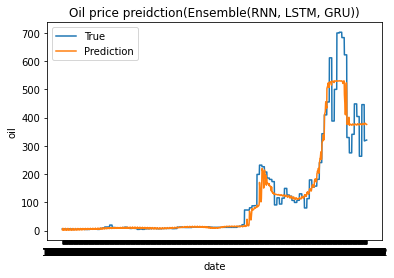

In [280]:
#x축 date(1900-01 ~ 2022-12) y축 oil price인 true값 그래프와 Ensemble모델(RNN, LSTM, GRU) 예측값 그래프 생성
plt.plot(oil.ID.values[seq_length:], oil['oil_price'][seq_length:], label = 'True')
plt.plot(oil.ID.values[seq_length:], model_4(torch.FloatTensor(X_seq)).cpu().detach().numpy()[:-1], label = 'Prediction')
plt.xlabel('date')
plt.ylabel('oil')
plt.title('Oil price preidction(Ensemble(RNN, LSTM, GRU))')
plt.legend()
plt.show()

In [276]:
#Ensemble(LSTM, GRU)
model_5 = Ensemble_Model_2(input_size, hidden_size, output_size, num_layers).to(device)
loss_func_5 = torch.nn.MSELoss().to(device)
optim_5 = torch.optim.Adam(params=model_5.parameters(), lr = lr )

In [277]:
#Ensemble(LSTM, GRU) 모델 training
train(model = model_5, dataloader = train_dataloader, eval_dataloader = valid_dataloader, loss_fn = loss_func_5, 
      optim = optim_5, epochs = epochs, device = device, patience = patience, verbose = verbose)

Epoch: 20, Train Loss: 31829.00973358, Validation Loss: 36952.83271088
EarlyStopping counter: 1 out of 30
Epoch: 40, Train Loss: 26286.16775680, Validation Loss: 30679.97988175
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
Epoch: 60, Train Loss: 22287.16031629, Validation Loss: 25864.82119965
EarlyStopping counter: 1 out of 30
Epoch: 80, Train Loss: 18791.79771820, Validation Loss: 22910.04008757
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 2 out of 30
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
Epoch: 100, Train Loss: 16376.18035786, Validation Loss: 19818.59944026
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
Epoch: 120, Train Loss: 14429.07144604, Validation Loss: 16747.93834428
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
EarlyStoppin

2331.7878623225474

In [278]:
#Ensemble(LSTM, GRU) 모델 test loss
print(f'model_5(Ensemble(LSTM, GRU)) Test Loss: {validation(model_5, test_dataloader, loss_func_5, device):.8f}')

model_5(Ensemble(LSTM, GRU)) Test Loss: 2829.94024979


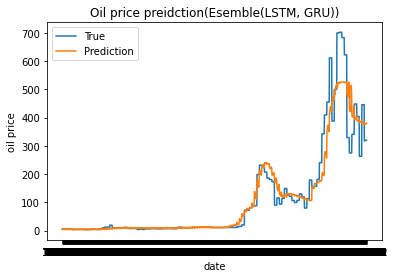

In [279]:
#x축 date(1900-01 ~ 2022-12) y축 oil price인 true값 그래프와 Ensemble모델(LSTM, GRU) 예측값 그래프 생성
plt.plot(oil.ID.values[seq_length:], oil['oil_price'][seq_length:], label = 'True')
plt.plot(oil.ID.values[seq_length:], model_5(torch.FloatTensor(X_seq)).cpu().detach().numpy()[:-1], label = 'Prediction')
plt.xlabel('date')
plt.ylabel('oil price')
plt.title('Oil price preidction(Esemble(LSTM, GRU))')
plt.legend()
plt.show()

In [281]:
test_loss = [validation(model_1, test_dataloader, loss_func_1, device),
            validation(model_2, test_dataloader, loss_func_2, device),
            validation(model_3, test_dataloader, loss_func_3, device),
            validation(model_4, test_dataloader, loss_func_4, device),
            validation(model_5, test_dataloader, loss_func_5, device)]

In [282]:
model_name = ["RNN", "LSTM", "GRU", "Ensemble(RNN, LSTM, GRU)", "Ensemble(LSTM, GRU)"]

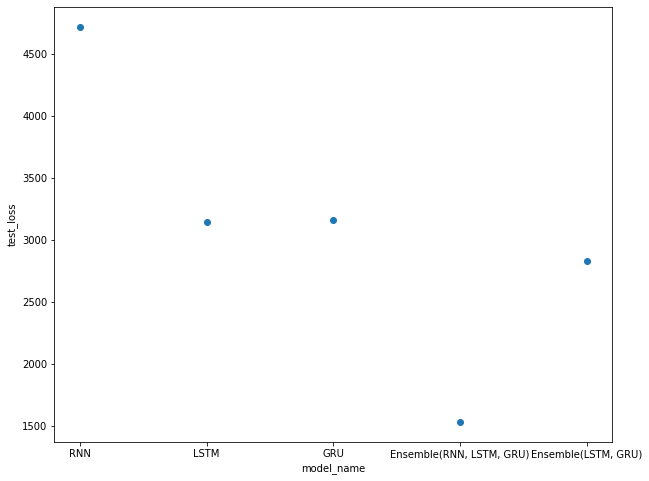

In [283]:
#model별 test loss를 plot
plt.figure(figsize=(10,8))
plt.scatter(model_name, test_loss)
plt.xlabel("model_name")
plt.ylabel("test_loss")
plt.show()

In [230]:
#모델예측을 위한 연,월 및 주 데이터 생성
#지금 seq_length가 12이므로 1월부터~12월까지의 데이터를 이용해 다음해 1월의 유가 예측하므로 2022년 데이터까지 사용
X_2022_to_2032 = np.array([])
for year in range(2022, 2032 + 1):
    for month in range(1, 13):
        X_2022_to_2032 = np.append(X_2022_to_2032, np.array([year, month]))

In [231]:
X_2022_to_2032 = X_2022_to_2032.reshape(-1, 2).astype(int)

In [232]:
#데이터 스케일링
X_2022_to_2032_scaled = scaler.transform(X_2022_to_2032)

In [248]:
#데이터를 sequence length만큼 이어줌
X_2022_to_2032_scaled_seq = data_to_seq(X_2022_to_2032_scaled, X_2022_to_2032_scaled.shape[1], seq_length)[:-1]

In [250]:
#유가 예측값
#4번째 모델(Ensemble(RNN, LSTM, GRU)의 test loss가 가장 작으므로 4번째 모델로 예측
oil_2023_to_2032 = model_4(torch.FloatTensor(X_2022_to_2032_scaled_seq)).cpu().detach().numpy()

In [251]:
X_2022_to_2032_df = pd.DataFrame(X_2022_to_2032)

In [262]:
#input데이터와 output데이터 합침
pred_2023_to_2032 = pd.DataFrame(np.hstack((X_2022_to_2032_df[X_2022_to_2032_df[0] != 2022].values,
                                            oil_2023_to_2032.reshape(-1,1))), columns = ['Year', 'Month', 'oil_price'])

In [265]:
pred_2023_to_2032['Year'] = pred_2023_to_2032['Year'].astype(int)
pred_2023_to_2032['Month'] = pred_2023_to_2032['Month'].astype(int)

In [266]:
#연, 월 column으로 id column 생성
pred_2023_to_2032['ID'] = pred_2023_to_2032['Year'].astype(str) + '-' + pred_2023_to_2032['Month'].apply(lambda x: str(x).zfill(2))

In [268]:
pred_2023_to_2032.drop(columns = ['Year', 'Month']).to_csv("/Users/jeonghongjun/python_project/AI_project/data/oil_price_2023_to_2032.csv")

In [269]:
torch.save(model_4, "/Users/jeonghongjun/python_project/AI_project/model/oil_price_model(Ensemble(RNN, LSTM, GRU)).pth")